# Recommendations for E-Commerce Sales Consumers



Our project is to build and deploy a personalized recommendation engine according to purchase patters of consumers.

## Dataset

Dataset cource: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail). 
It transactions occurring between 01/12/2010 and 09/12/2011 for an online retail store. 

Data columns:
+ InvoiceDate: Invoice Date and time. the day and time for each transaction
+ InvoiceNo: Invoice number, a 6-digit number assigned to each transaction. If code starts with 'c', it signifies a cancellation.
+ UnitPrice: Unit price. Product price per unit in sterling.
+ StockCode: Product code, a 5-digit number assigned to each distinct product.
+ Description: Product name
+ CustomerID: Customer number, a 5-digit number assigned to each customer.
+ Country: Country of residence for customer.
+ Quantity: The quantities of each product per transaction.



## Data Preprocessing


In [ ]:
!pip install sagemaker seaborn scipy scikit-learn

In [2]:
import sagemaker
import sagemaker.amazon.common as smac
import boto3

import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
print(f"using bucket{bucket} in region {region} \n")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
using bucketsagemaker-us-east-1-767397762857 in region us-east-1 



In [4]:
df = pd.read_csv("data/Online Retail.csv")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

delete rows with a missing CustomerID

In [6]:
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
print(df.shape)

(406829, 8)


/tmp/ipykernel_2290/358367252.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["Quantity"], shade=True)  # shade=True shades the area under the curve


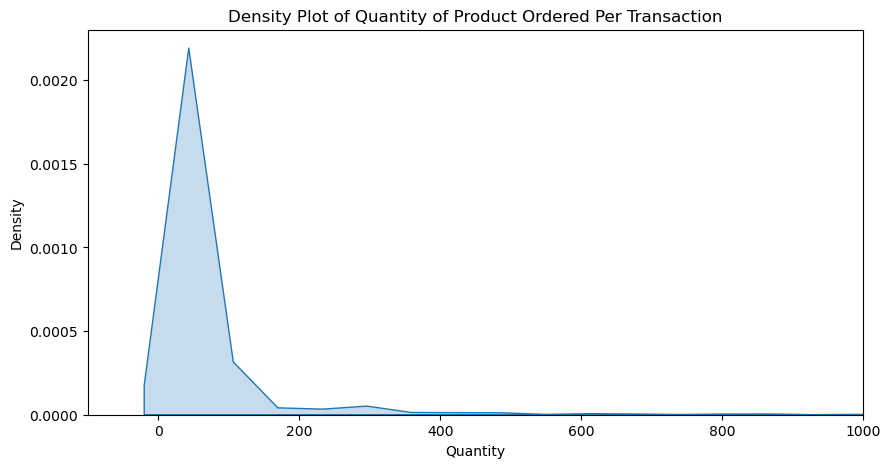

In [40]:
plt.figure(figsize=(10, 5))

# Create a density plot using seaborn
sns.kdeplot(df["Quantity"], shade=True)  # shade=True shades the area under the curve

plt.title("Density Plot of Quantity of Product Ordered Per Transaction")
plt.xlabel("Quantity")
plt.ylabel("Density")
plt.xlim(-100, 1000)

plt.show()

Most of our quantities are realteively small (positive) numbers, but there are also some negative quantities as well as extreme outliers (both postiive and negative outliers). 

/tmp/ipykernel_2290/3431790728.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["UnitPrice"], shade=True)  # shade=True shades the area under the curve


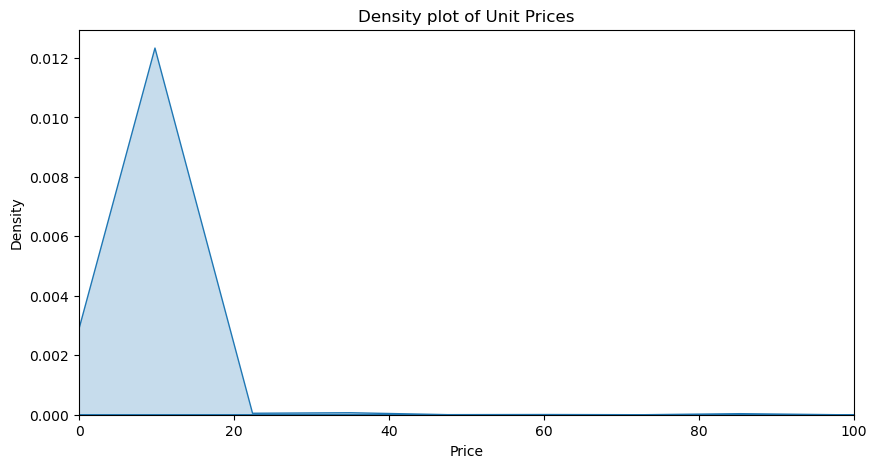

In [68]:
plt.figure(figsize=(10, 5))

# Create a density plot using seaborn
sns.kdeplot(df["UnitPrice"], shade=True)  # shade=True shades the area under the curve

plt.title("Density plot of Unit Prices")
plt.xlabel("Price")
plt.ylabel("Density")
plt.xlim(0, 100)

plt.show()


There are no negative prices, which is good, but we can see some extreme outliers.

In [69]:
df.describe()

,CustomerID,UnitPrice,Quantity,invoice_amount
count,274399.000000,274399.000000,274399.000000,274399.000000
mean,15279.568249,3.002736,17.972722,30.657294
std,1708.737032,11.452789,86.687684,157.080140
min,12347.000000,0.000000,1.000000,0.000000
25%,13871.000000,1.250000,2.000000,5.900000
50%,15218.000000,1.690000,6.000000,14.850000
75%,16775.000000,3.750000,12.000000,23.400000
max,18287.000000,2500.000000,12540.000000,39619.500000


In [10]:
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
    "Quantity"
].sum()
df = df.loc[df > 0].reset_index()
df.shape

(274399, 6)

In [11]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [12]:
X, y = loadDataset(df)

In [13]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.9991284988048746

data is over 99.9% sparse. This allows the sparse matrix data type to represent the data using less memory than a dense matrix would require.

### Protbuf setup and splitting data for model prep

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

In [15]:
df.to_csv("data/online_retail_preprocessed.csv", index=False)
save_npz("data/X_train.npz", X_train)
save_npz("data/X_test.npz", X_test)
np.savez("data/y_train.npz", y_train)
np.savez("data/y_test.npz", y_test)

In [16]:
prefix = "personalization"

train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [17]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)


train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))

s3://sagemaker-us-east-1-767397762857/personalization/train/train.protobuf
s3://sagemaker-us-east-1-767397762857/personalization/test/test.protobuf
Output: s3://sagemaker-us-east-1-767397762857/personalization/output


We plan on training, tuning, and deploying the model trained on the data prepared above

### Project Plan
![Project Plan](./images/retail_rec_proposal_plan.png)